# Hackathon #2

Written by Eleanor Quint

Topics: 
- Dense layers
- Training by minibatch/gradient step and epoch
- Splitting the dataset into train/validation

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [2]:
%matplotlib inline
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops
import seaborn as sns

sns.set(rc={'axes.facecolor':'darkgrey', 'figure.facecolor':'darkgrey'})
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
    facecolor='#23272e',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    facecolor='#23272e',
)
plt.rc(
	"xtick",
	color="#cccccc",
)
plt.rc(
	"ytick",
	color="#cccccc",
)



DATA_DIR = './tensorflow-datasets/'

c:\Users\kvanv\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### A First Attempt at Classifying MNIST

MNIST is a dataset of greyscale 28x28 handwritten digits labelled 0 through 9. We'll use it for a 10-class problem to learn the basics of classification.

Let's have a look at the data first. We'll load the data from [Tensorflow Datasets](https://www.tensorflow.org/datasets) and visualize it with matplotlib's `plt.imshow`.

data shape: (32, 28, 28, 1)
label: tf.Tensor([2 0 7 9 2 1 4 1 6 1 3 9 4 1 6 8 1 6 1 4 0 7 1 8 9 1 1 2 0 0 2 5], shape=(32,), dtype=int64)
An image looks like this:
It's colored because matplotlib wants to provide more contrast than just greys


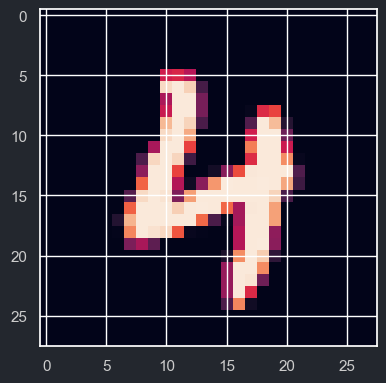

In [3]:
ds = tfds.load('mnist', data_dir=DATA_DIR, shuffle_files=True) # this loads a dict with the datasets

# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32)

# Looping through the iterator, each batch is a dict
for batch in train_ds:
    # The first dimension in the shape is the batch dimension
    # The second and third dimensions are height and width
    # Being greyscale means that the image has one channel, the last dimension in the shape
    print("data shape:", batch['image'].shape)
    print("label:", batch['label'])
    break

# visualize some of the data
idx = np.random.randint(batch['image'].shape[0])
print("An image looks like this:")
imgplot = plt.imshow(batch['image'][idx])
print("It's colored because matplotlib wants to provide more contrast than just greys")

#### Dense layers

The first step to building a simple neural network is to specify layers. The most basic building block is the dense layer (AKA linear layer or fully connected layer), so we'll declare a function that creates the layer. Each dense layer is composed of two variables, the weight matrix `W` and the bias vector `b` as well as a non-linear activation function `a`, to calculate the function `f(x) = a(Wx + b)`.

Normally we'll use pre-defined layers, but in this notebook we'll do it ourselves first to better understand what's going on under the hood.

In [4]:
class Dense(tf.Module):
    def __init__(self, output_size, activation=tf.nn.relu):
        """
        Args:
            - output_size: (int) number of neurons
            - activation: (function) non-linear function applied to the output
        """
        self.output_size = output_size
        self.activation = activation
        self.is_built = False
        
    def _build(self, x):
        data_size = x.shape[-1]
        self.W = tf.Variable(tf.random.normal([data_size, self.output_size]), name='weights')
        self.b = tf.Variable(tf.random.normal([self.output_size]), name='bias')
        self.is_built = True

    def __call__(self, x):
        if not self.is_built:
            self._build(x)
        return self.activation(tf.matmul(x, self.W) + self.b)

The first dimension of the input is the "batch" dimension, which allows us to run many data through the model simultaneously. The matrix `W` has a row for each input dimension so that each column corresponds to the weights of one linear unit of the layer. After adding the bias vector to the vector resulting from the vector-matrix multiplication, we activate with a non-linearity.

Let's define a simple, two layer network with this function. We activate the first layer with the rectified linear function [`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu), but not the second layer so that we can interpret its output as the [logits](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow) of a discrete probability distribution. Note that we're going to flatten the data into a vector (784 = 28 x 28) so that we can use it with a linear layer (we encountered `tf.reshape` in the last hackathon). Loss is calculated with [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy), which implies that we're interpreting the output of the neural network as the paramters of a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution).

Further, we'll train with minibatches of data with the for loop (using tqdm for a progress bar). We run the data forward in each minibatch, calculate the loss using the output logits and correct label, calculate gradients, and finally backprop gradients using the 

100%|██████████| 1875/1875 [00:06<00:00, 288.32it/s]


Accuracy: 0.100666665


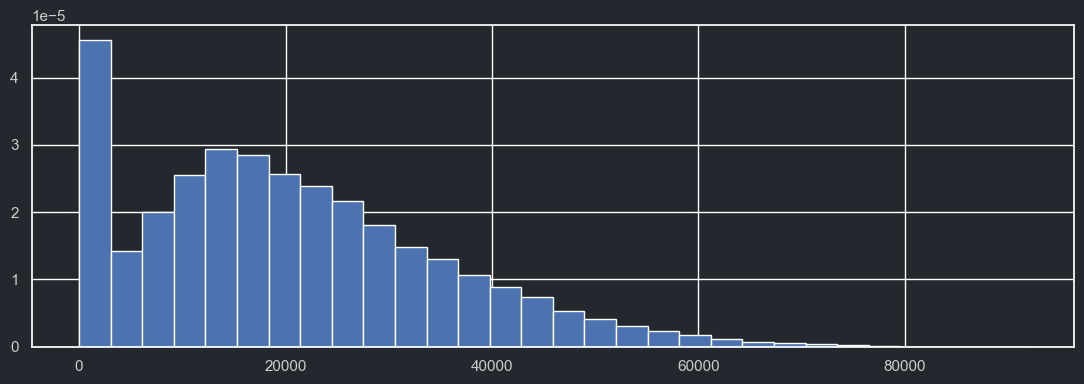

In [4]:
first_layer = Dense(200)
second_layer = Dense(10)

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for batch in tqdm(train_ds):
    # run network
    x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784]) # -1 means everyting not otherwise accounted for
    labels = batch['label']
    x = first_layer(x)
    logits = second_layer(x)
    
    # calculate loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss_values.append(loss)
    
    # calculate accuracy
    predictions = tf.argmax(logits, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    accuracy_values.append(accuracy)

# print accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

#### Training by minibatch/gradient step and epoch

Now let's re-declare the network with pre-defined layers using [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), group the layers using [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), and training the parameters with the [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer.

Note how [`tf.GradientTape`](https://www.tensorflow.org/guide/autodiff) is used. We run all the computations which we want to backpropagate gradients through in the scope of the tape and then, after the loss is calculated, we can call `tape.gradient` to calculate the gradient of the output with respect to the model variables.

100%|██████████| 1875/1875 [00:14<00:00, 130.68it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 200)                 157000    
                                                                 
 dense_1 (Dense)             (32, 10)                  2010      
                                                                 
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________


None
Accuracy: 0.88265


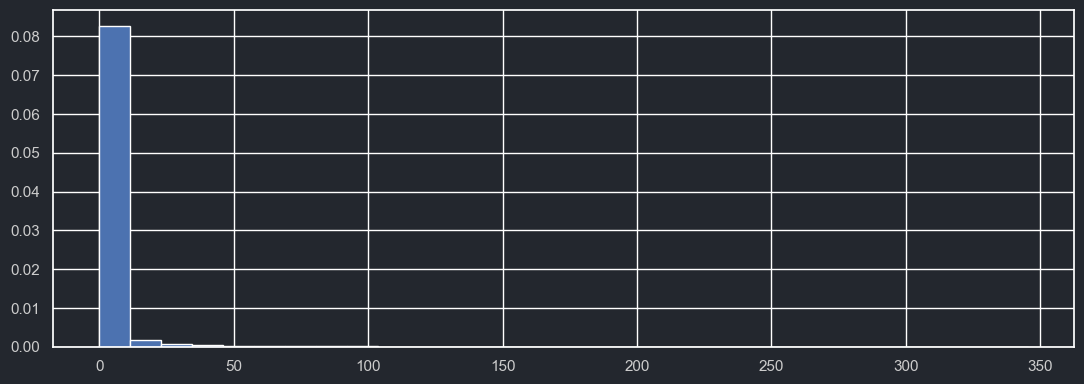

In [5]:
# using Sequential groups all the layers to run at once
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for epoch in range(1):
    for batch in tqdm(train_ds):
        with tf.GradientTape() as tape:
            # run network
            x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
            labels = batch['label']
            logits = model(x)

            # calculate loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
        loss_values.append(loss)
    
        # gradient update
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        # calculate accuracy
        predictions = tf.argmax(logits, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
        accuracy_values.append(accuracy)

print(model.summary())
    
# accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

#### Splitting the dataset into train/validation

After one epoch of training the loss values drop dramatically and accuracy rises from change (\~10%) to that of a decent classifier (\~85-90%). In practice we want to train for many epochs and use the set of parameters which gives the lowest validation error. Unfortunately, we don't know which set of parameters is best because we're training on all the data. Before training, we should split the training dataset into a train set, which will be used for parameter updates, and a validation set, which will not. Then, we can determine which parameters generalise best by calculating the accuracy on the hold-out validation set. The parameters with the highest accuracy on validation will likely generalise the best.

The easiest way to do this is with TensorFlow Datasets is to use their string indexing notation when loading the datasets.

In [5]:
# The first 90% of the training data
# Use this data for the training loop
train = tfds.load('mnist', split='train[:90%]', data_dir=DATA_DIR)

# And the last 10%, we'll hold out as the validation set
# Notice the python-style indexing, but in a string and with percentages
# After the training loop, run another loop over this data without the gradient updates to calculate accuracy
validation = tfds.load('mnist', split='train[-10%:]', data_dir=DATA_DIR)

### Homework

Your homework is to specify a network with `tf.keras.layers`, train it on the MNIST dataset (as above, but with train/validation split), and try out 2 or 3 variations of different architectures. I.e., change the number of neurons or layers, change the activation function (you can find more in the documentation at [`tf.nn`](https://www.tensorflow.org/api_docs/python/tf/nn)), or even change the optimizer ([`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)). Write up a paragraph or two with your observations. E.g., how did it affect the final accuracy on the validation data? How did it affect the rate at which the model improved? Remember to add early stopping and increase the number of training epochs. Submit a `.pdf` with the writeup and `.py` with the code.

I'm expecting this to take about an hour (or less if you're experienced). Feel free to use any code from this or previous hackathons. If you don't understand how to do any part of this or if it's taking you longer than that, please let me know in office hours or by email (both can be found on the syllabus). I'm also happy to discuss if you just want to ask more questions about anything in this notebook!

### Coda

In [6]:
from IPython.display import HTML
from math import trunc
# From Colah's Blog, linearly separating spirals with linear transforms and non-linearities
# How does a neural network separate entangled data?
print("We want the blue and red lines to be linearly separable, so how does a neural network manage to do this?\
 Let's visualize the linear transformations and non-linearities.")
HTML('<img src="http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/spiral.1-2.2-2-2-2-2-2.gif">')

We want the blue and red lines to be linearly separable, so how does a neural network manage to do this? Let's visualize the linear transformations and non-linearities.


data shape: (32, 28, 28, 1)
label: tf.Tensor([2 0 2 4 4 8 1 4 1 1 2 4 2 3 9 4 2 6 6 6 3 2 9 2 5 5 2 0 3 5 3 6], shape=(32,), dtype=int64)
An image looks like this:
It's colored because matplotlib wants to provide more contrast than just greys


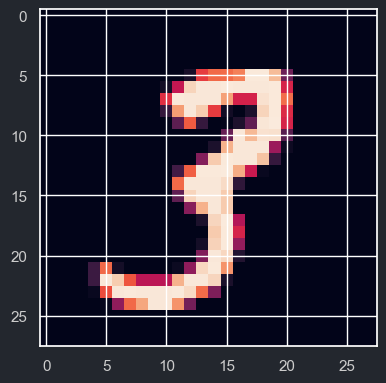

In [7]:
train_g = train.shuffle(1024).batch(32)

# Looping through the iterator, each batch is a dict
for batch in train_g:
    # The first dimension in the shape is the batch dimension
    # The second and third dimensions are height and width
    # Being greyscale means that the image has one channel, the last dimension in the shape
    print("data shape:", batch['image'].shape)
    print("label:", batch['label'])
    break

# visualize some of the data
idx = np.random.randint(batch['image'].shape[0])
print("An image looks like this:")
imgplot = plt.imshow(batch['image'][idx])
print("It's colored because matplotlib wants to provide more contrast than just greys")

100%|██████████| 1688/1688 [00:18<00:00, 90.38it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 218,310
Trainable params: 218,310
Non-trainable params: 0
_________________________________________________________________


None
Accuracy: 0.96889466
Epoch Count: 16.0


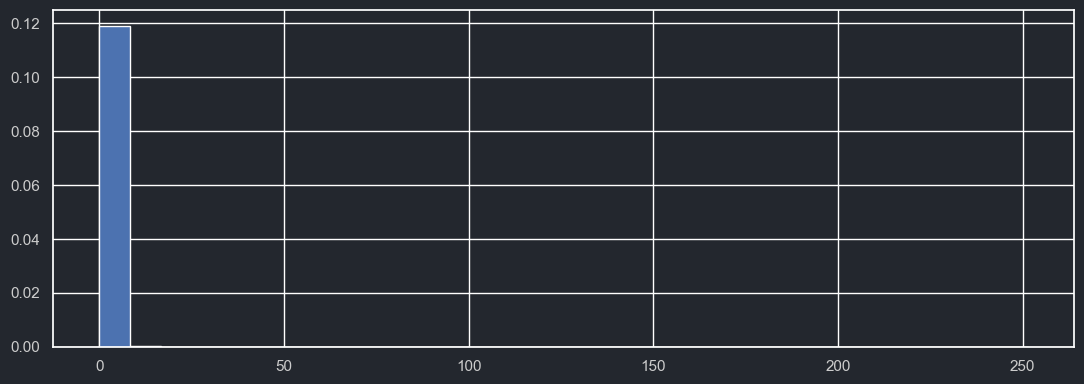

In [8]:
# using Sequential groups all the layers to run at once
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(100, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for epoch in range(40): # ~15s/epoch ~= 10 min max
    for batch in tqdm(train_g):
        with tf.GradientTape() as tape:
            # run network
            x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
            labels = batch['label']
            logits = model(x)

            # calculate loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
        loss_values.append(loss)
    
        # gradient update
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        # calculate accuracy
        predictions = tf.argmax(logits, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
        accuracy_values.append(accuracy)
        
    if len(loss_values)/1688 > 10 and trunc(np.mean(loss_values[-1]) * 100) == trunc(np.mean(loss_values[-4]) * 100):
        break

print(model.summary())
    
# accuracy
print("Accuracy:", np.mean(accuracy_values))
print("Epoch Count:", len(loss_values)/1688)
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

In [22]:
type(loss_values[0])

tensorflow.python.framework.ops.EagerTensor

In [9]:
validation_g = validation.shuffle(1024).batch(32)

100%|██████████| 188/188 [00:01<00:00, 134.61it/s]


Accuracy: 0.9695811


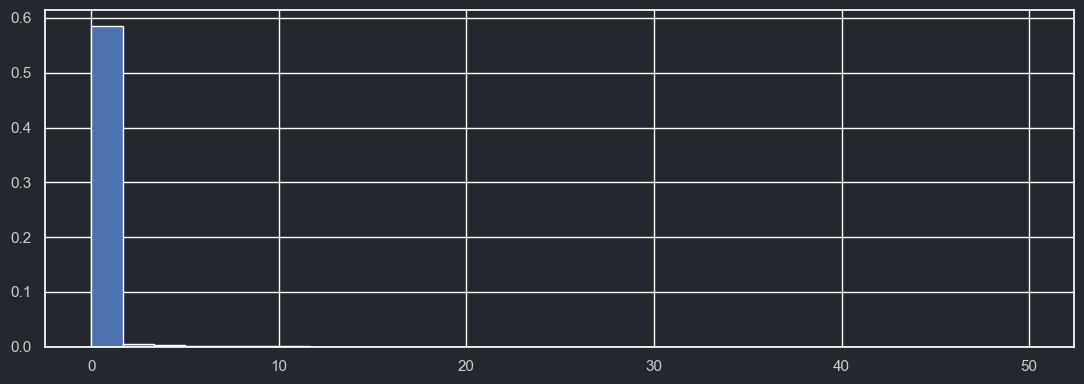

In [10]:
val_accuracy = []
val_loss = []
for batch in tqdm(validation_g):
        with tf.GradientTape() as tape:
            # run network
            x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
            labels = batch['label']
            logits = model(x)

            # calculate loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
        val_loss.append(loss)
    
        # gradient update -- NO
        # grads = tape.gradient(loss, model.trainable_variables)
        # optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        # calculate accuracy
        predictions = tf.argmax(logits, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
        val_accuracy.append(accuracy)
print("Accuracy:", np.mean(val_accuracy))
val_loss = np.concatenate(val_loss)
plt.hist(val_loss, density=True, bins=30)
plt.show()

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
### M1

 dense_8 (Dense)             (None, 200)               157000    
                                                                 
 dense_9 (Dense)             (None, 10)                2010      

### M2

 dense_22 (Dense)            (None, 200)               157000    
                                                                 
 dense_23 (Dense)            (None, 100)               20100     
                                                                 
 dense_24 (Dense)            (None, 10)                1010      
 
### M3

 dense_6 (Dense)             (None, 200)               157000    
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                               
 
### M4

 dense_6 (Dense)             (None, 200)               157000    
                                                                 
 dense_7 (Dense)             (None, 200)               20100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 10)                1010     

 | Model |Accuracy | Epochs (max) | Patince | S fraction | Activation |
 |-------|---------|--------|---------|------------|---------|
 | M1 | 0.9537899 | 100 (100)	| inf | n/a| relu |
 | M1 | 0.9474734 | 10 (40)	| 3 | 100 | relu |
 | M1 |  0.94132316  | 32 (40) | 3 | 1000| relu |
 | M1 |  0.9325133 | 40 (40) | 3 | 100| relu6 |
 | M2 | 0.9617686 | 10 (40) | 3 | 1000| relu |
 |M3 | 0.96891624 | 9 (40) | 3 | 100| relu |
 |M4 | 0.9695811 | 16 (40) | 3 | 100| relu |